In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
%matplotlib inline

In [87]:
class DataPlotter:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def get_all_features_observed(self):
        x_train_observed = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        return x_train_observed.columns

    def get_all_features_estimated(self):
        x_train_estimated = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        return x_train_estimated.columns
    
    def plot_feature_against_y(self, feature, observed, hour=None, month=None):
        if observed:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        else:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        
        # Convert 'time' and 'date_forecast' columns to datetime format
        y_train['time'] = pd.to_datetime(y_train['time'])
        x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

        if hour and month:
            print("HOUR =", hour,"AND MONTH =", month)
            y_train_at_hour_and_month = y_train[
                (y_train['time'].dt.hour == hour) & (y_train['time'].dt.month == month)
            ]
            x_train_at_hour_and_month = x_train[
                (x_train['date_forecast'].dt.hour == hour) & (x_train['date_forecast'].dt.month == month)
            ]
            merged_df = pd.merge(
                y_train_at_hour_and_month, x_train_at_hour_and_month,
                left_on='time', right_on='date_forecast'
            )
        elif hour and not month:
            print("HOUR =", hour)
            y_train_at_hour = y_train[y_train['time'].dt.hour == hour]
            x_train_at_hour = x_train[x_train['date_forecast'].dt.hour == hour]
            merged_df = pd.merge(
                y_train_at_hour, x_train_at_hour, left_on='time', right_on='date_forecast'
            )
        elif month and not hour:
            print("MONTH =", month)
            y_train_at_month = y_train[y_train['time'].dt.month == month]
            x_train_at_month = x_train[x_train['date_forecast'].dt.month == month]
            merged_df = pd.merge(
                y_train_at_month, x_train_at_month, left_on='time', right_on='date_forecast'
            )
        elif not month and not hour:
            print(y_train.columns)
            merged_df = pd.merge(y_train , x_train, left_on='time', right_on='date_forecast')

        plt.figure(figsize=(8, 5))
        plt.scatter(merged_df[feature], merged_df['pv_measurement'], alpha=1)
        plt.xlabel(feature)
        plt.ylabel('PV Measurement')
        plt.title(feature + ' vs PV Measurement')
        plt.grid(True)
        plt.show()
    
    def plot_feature_analysis(self, observed, feature=None, hour=None, month=None):
        if observed:
            if feature:
                print(feature + " FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                self.plot_feature_against_y(feature, observed=True, hour=hour, month=month)
            else:
                print("ALL FEATURES PLOTTED FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_observed():
                    self.plot_feature_against_y(feature, observed=True, hour=hour, month=month)
        else:
            if feature:
                print(feature + " FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                self.plot_feature_against_y(feature, observed=False, hour=hour, month = month)
            else:
                print("ALL FEATURES PLOTTED FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_estimated():
                    self.plot_feature_against_y(feature, observed=False, hour=hour, month = month)

In [92]:
# Choose what dataset you want your values from (observed = False gets the estimated dataset).
# This will output all features in the dataset

dataset = 'B'
observed = True

plotter = DataPlotter(dataset)

if observed: print(plotter.get_all_features_observed())
else: print(plotter.get_all_features_estimated())

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

air_density_2m:kgm3 FROM OBSERVED DATASET FROM LOCATION B.
HOUR = 12 AND MONTH = 7


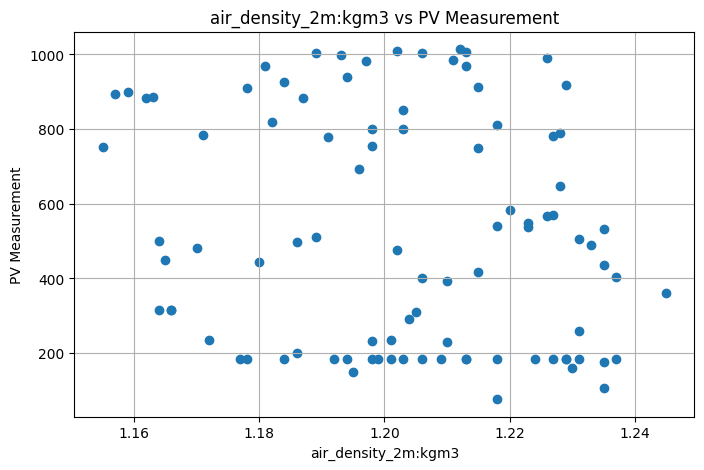

In [94]:
# Spesify hour (example: 12) and/or month (example: 6)
# Choose your feature. If you spesify 'feauture' to be None, then it will plot for ALL feautures.

hour = 12
month = 7
feature = 'air_density_2m:kgm3'

plotter.plot_feature_analysis(observed=observed, feature=feature, hour=hour, month=month)